<a href="https://colab.research.google.com/github/Joselyne50/DEEPLEARNING/blob/main/Jossy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [122]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [123]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True

        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True

        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1

        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1

        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

You need to complete the learn() method of the following class to implement your RL algorithm.


In [124]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.growing_values = {}
        self.q_table = {(agent_x, agent_y, box_x, box_y) : {k: 0 for k in self.action_space} for agent_x in range(env.world_height)
                        for agent_y in range(env.world_width)
                        for box_x in range(env.world_height)
                        for box_y in range(env.world_width)
                        }
        self.growing_values = {state: 0 for state in list(self.q_table.keys())}
        self.countState = copy.deepcopy(self.growing_values)
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def act(self, state):
        """Epsilon-greedy action selection."""
        epsilon = 0.1
        if np.random.uniform(0, 1) < epsilon:
            return np.random.choice(self.action_space)
        q_values = {action: self.q_table.setdefault(state, {}).setdefault(action, 0) for action in self.action_space}
        return max(q_values, key=q_values.get)

    # UPDATING Q-VALUES
    def Update(self, state, action, reward, next_state):
        max_next_q_value = max([self.q_table.setdefault(state, {}).setdefault(action, 0) for a in self.action_space])
        current_q_value = self.q_table.setdefault(state, {}).setdefault(action, 0)
        self.q_table[state][action] = current_q_value + self.alpha * (reward + self.gamma * max_next_q_value - current_q_value)

    def learn(self):
        rewards = []
        self.MeanValues = []
        for _ in range(self.num_episodes):
            cumulative_reward = 0
            state = self.env.reset()
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                self.Update(state, action, reward, next_state)
                state = next_state
                # Save growing value and renew counts
                self.growing_values[state] += max(self.q_table[state].values())
                self.countState[state] += 1
                cumulative_reward += reward
            rewards.append(cumulative_reward)

            # calculate average growing value (v_values)
            Mean_growingValue = np.mean([max(play.values()) for play in self.q_table.values()])
            self.MeanValues.append(Mean_growingValue)
        return rewards

    def display_v_table(self):
        return {state: max(actions.values()) for state, actions in self.q_table.items()}

    def display_policy(self):
        return {state: max(actions, key=actions.get) for state, actions in self.q_table.items()}

    def ShowMeanValuesTable(self):
      h, w = (self.env.world_height, self.env.world_width)
      v_dataframe = np.zeros((h, w))

      for ax in range(h):
        for ay in range(w):
          total_values = []
          for bx in range(h):
            for by in range(w):
              state = (ax, ay, bx, by)
              avg_v_for_state = self.growing_values[state] / self.countState[state] if self.countState[state] > 0 else 0
              total_values.append(avg_v_for_state)
          v_dataframe[ax, ay] = np.mean(total_values)
      # Mean_VdataFrame = np.array([np.mean([self.growing_values[(ax, ay, bx, by)] / self.countState[(ax, ay, bx, by)]]) if self.countState[(ax, ay, bx, by)] > 0 else 0 for bx in range(h) for by in range(w) for ay in range(w)] for ax in range(h))
      return pd.DataFrame(v_dataframe)
      # [print(' | '.join([f"{v_dataframe[ax, ay]:.2f}" for ay in range(w)])) for ax in range(h)]
      # print("*" * 100)


    def display_policy(self):
        """Display the learned policy along with the expected reward."""
        policy_with_rewards = {state: (max(actions, key=actions.get), max(actions.values())) for state, actions in self.q_table.items()}

        # Optional: Display the policy and rewards in a human-readable format
        rows = []
        for state, (action, reward) in policy_with_rewards.items():
            rows.append([state, action, f"{reward:.2f}"])
        # print("-" * 40)
        return rows


Here is the game interface where you can manually move the agent.

In [125]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
  try:
    action = int(input("Please input the actions \nup: 1, \ndown: 2, \nleft: 3, \nright: 4 \nExit Game: 0 \n: "))
    if not action:
      break
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()
  except Exception:
    print()
    print('Invalid action', '\n', '_'*100)

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
Please input the actions 
up: 1, 
down: 2, 
left: 3, 
right: 4 
Exit Game: 0 
: 2
step: 1, state: (5, 0, 4, 1), actions: 2, reward: -15
Action: 2
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_

Training The Agent

In [126]:
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=2000)
rewards = agent.learn()
# shape = (CliffBoxGridWorld.world_height, CliffBoxGridWorld.world_width)  # Define the shape of your environment grid
df = agent.ShowMeanValuesTable()

In [127]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-9.787145,-9.659864,-8.659786,-6.562027,-4.623019,-3.352760,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,-11.447261,-10.990603,-10.208076,-6.851610,-4.353289,-3.105280,0.000000,0.000000,-0.016667,-0.014127,-0.005714,0.0,0.0,0.0
2,-14.420267,-15.601642,-14.853931,0.000000,-2.759972,-2.335702,0.000000,0.000000,-0.058567,-0.043804,-0.015473,0.0,0.0,0.0
3,-17.483334,-18.949677,-17.703104,0.000000,-1.880479,-1.665577,0.000000,-0.184139,-0.130263,-0.084404,-0.043858,0.0,0.0,0.0
4,-20.241431,-18.288511,-14.920333,0.000000,-1.377614,-1.161519,-0.650296,-0.339679,-0.195199,-0.116676,-0.053332,0.0,0.0,0.0
5,-22.274688,-20.272257,-16.704203,0.000000,-1.032456,-0.904804,-0.603859,-0.340435,-0.205243,-0.098015,-0.031923,0.0,0.0,0.0


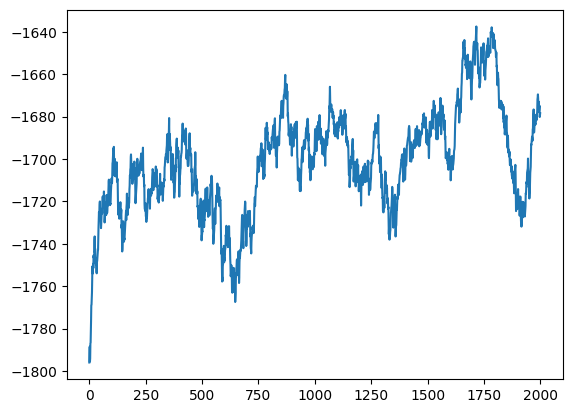

In [128]:
# Smooth plot
weight=0.99
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)

You need to complete the following method to visualize your training results.

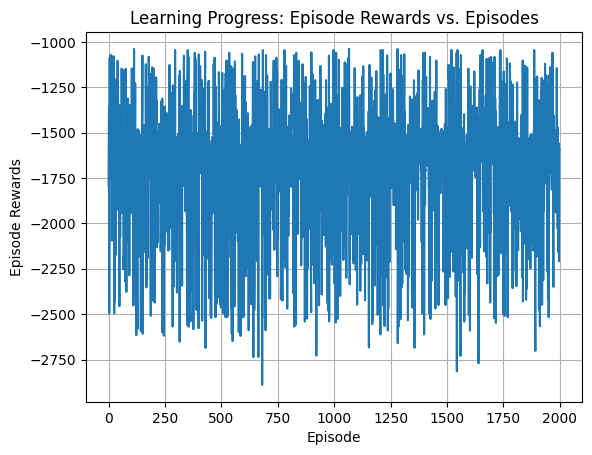

In [129]:
#Ploting Learning progress
plt.plot(range(len(rewards)), rewards)
plt.xlabel('Episode')
plt.ylabel('Episode Rewards')
plt.title('Learning Progress: Episode Rewards vs. Episodes')
plt.grid(True)
plt.show()

In [132]:
policy = agent.display_policy()
pol_df = pd.DataFrame(policy, columns = ["State", "Action", f"Rewards"])
pol_df
# print(pol_df[pol_df['Rewards'] != '0.00'])

,State,Action,Rewards
0,"(0, 0, 0, 0)",1,0.00
1,"(0, 0, 0, 1)",1,0.00
2,"(0, 0, 0, 2)",1,0.00
3,"(0, 0, 0, 3)",1,0.00
4,"(0, 0, 0, 4)",1,0.00
5,"(0, 0, 0, 5)",1,0.00
6,"(0, 0, 0, 6)",1,0.00
7,"(0, 0, 0, 7)",1,0.00
8,"(0, 0, 0, 8)",1,0.00
9,"(0, 0, 0, 9)",1,0.00
